In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# graph settings for notebooks
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6) # Set default figure size
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


In [2]:
# 1. load data
data_path = '../data/cleaned_data.csv'
df = pd.read_csv(data_path)

# 2. make 'Date' column datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 3. Collect data weekly (W - Weekly) (Resampling)
weekly_sales = df['Total Amount'].resample('W').sum()

print(f"✅ Data Resampled to Weekly Sales. Total Weeks: {len(weekly_sales)}")
display(weekly_sales.head())

✅ Data Resampled to Weekly Sales. Total Weeks: 54


Date
2023-01-01     1691
2023-01-08    12877
2023-01-15    12965
2023-01-22     8098
2023-01-29    10387
Freq: W-SUN, Name: Total Amount, dtype: int64

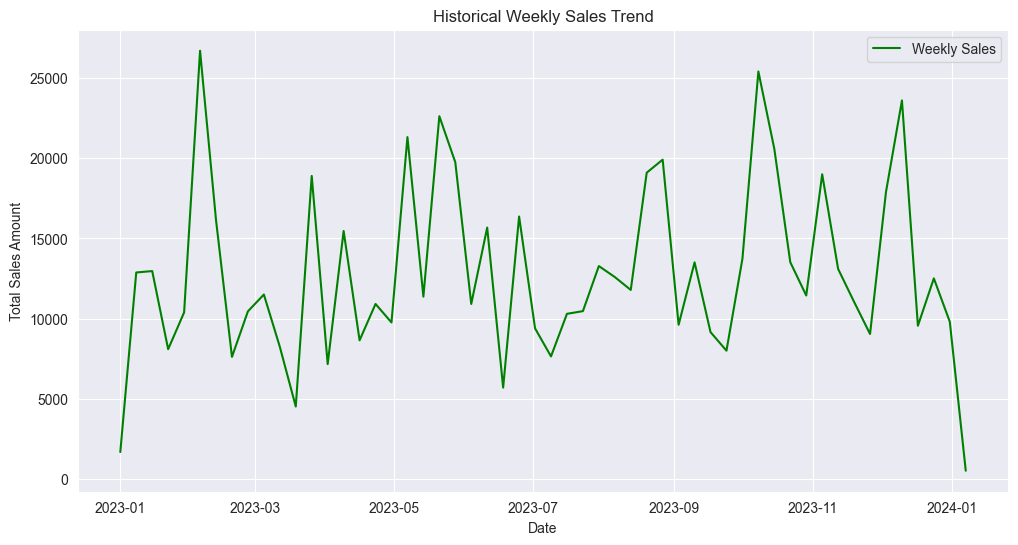

In [3]:
# Plot the historical data
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales, label='Weekly Sales', color='green')
plt.title('Historical Weekly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Split data: 80% for training, 20% for testing
train_size = int(len(weekly_sales) * 0.8)
train_data, test_data = weekly_sales[0:train_size], weekly_sales[train_size:]

print(f"Training Weeks: {len(train_data)}")
print(f"Testing Weeks: {len(test_data)}")

Training Weeks: 43
Testing Weeks: 11


In [5]:
# Initialize ARIMA model
# order=(p,d,q) -> (5,1,0) is a standard starting point for moving trends
model = ARIMA(train_data, order=(5,1,0))

# Train the model
model_fit = model.fit()

print("✅ ARIMA Model Trained Successfully!")
print(model_fit.summary())

✅ ARIMA Model Trained Successfully!
                               SARIMAX Results                                
Dep. Variable:           Total Amount   No. Observations:                   43
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -426.899
Date:                Sun, 11 Jan 2026   AIC                            865.798
Time:                        20:58:33   BIC                            876.224
Sample:                    01-01-2023   HQIC                           869.620
                         - 10-22-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6288      0.181     -3.479      0.001      -0.983      -0.275
ar.L2         -0.4465      0.180     -2.476      0.013      -0.800      -0.093
ar.L3         -0

In [6]:
# Forecast on the test set range
forecast_result = model_fit.get_forecast(steps=len(test_data))
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int() # Confidence intervals

# RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast_values))
print(f"📊 Root Mean Squared Error (RMSE): {rmse:.2f}")

📊 Root Mean Squared Error (RMSE): 7554.29


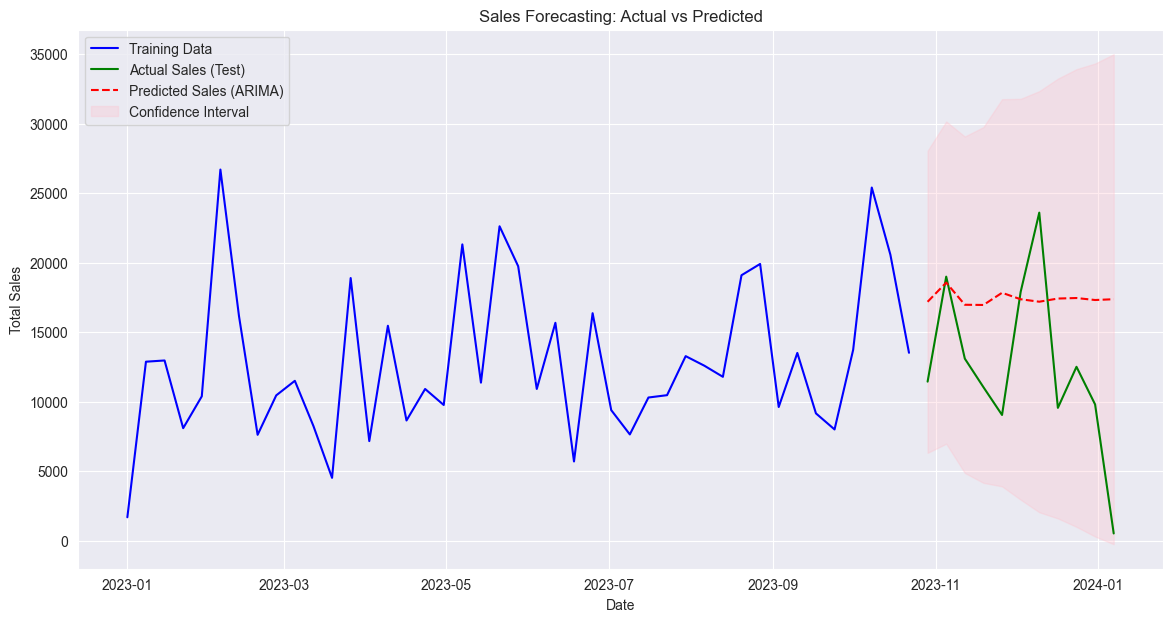

In [7]:
plt.figure(figsize=(14, 7))

# 1. training data
plt.plot(train_data.index, train_data, label='Training Data', color='blue')

# 2. Real Test Data
plt.plot(test_data.index, test_data, label='Actual Sales (Test)', color='green')

# 3. our Predictions
plt.plot(test_data.index, forecast_values, label='Predicted Sales (ARIMA)', color='red', linestyle='--')

# 4. Confidence Interval (Optional: possible lower and upper bounds of the prediction)
plt.fill_between(test_data.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Sales Forecasting: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Retrain model on FULL data to predict the unknown future
final_model = ARIMA(weekly_sales, order=(5,1,0))
final_model_fit = final_model.fit()

# Predict next 4 weeks
future_steps = 4
future_forecast = final_model_fit.get_forecast(steps=future_steps)
future_dates = pd.date_range(start=weekly_sales.index[-1], periods=future_steps+1, freq='W')[1:]

print("🔮 Next 4 Weeks Sales Forecast:")
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Sales': future_forecast.predicted_mean})
display(forecast_df)

🔮 Next 4 Weeks Sales Forecast:


,Date,Predicted Sales
2024-01-14,2024-01-14,6830.094547
2024-01-21,2024-01-21,9075.091546
2024-01-28,2024-01-28,7239.972024
2024-02-04,2024-02-04,6389.995858


In [9]:
# Save the trained ARIMA model
model_path = '../models/forecasting_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model_fit, f)

print(f"💾 Forecasting Model saved to: {model_path}")

💾 Forecasting Model saved to: ../models/forecasting_model.pkl
